In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO_BN(conv_num=1):
    kernel_size = 64
    filter_size = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3*kernel_size, filters=filter_size, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        target_kernel_size = 3 * (kernel_size//(2**(i+1)))
        model.add(Conv1D (kernel_size=target_kernel_size if target_kernel_size != 0 else 3, 
                          filters=filter_size*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        24704     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        1572992   
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 128)        512       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 128)        24704     
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 128)        1572992   
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 128)        24704     
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 128)        1572992   
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.5918 - acc: 0.3699
Epoch 00001: val_loss improved from inf to 2.16208, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_3_conv_checkpoint/001-2.1621.hdf5
36805/36805 [==============================] - 387s 11ms/sample - loss: 3.5913 - acc: 0.3700 - val_loss: 2.1621 - val_acc: 0.4521
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8277 - acc: 0.5726
Epoch 00002: val_loss improved from 2.16208 to 1.73431, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_3_conv_checkpoint/002-1.7343.hdf5
36805/36805 [==============================] - 380s 10ms/sample - loss: 1.8279 - acc: 0.5726 - val_loss: 1.7343 - val_acc: 0.5940
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4230 - acc: 0.6615
Epoch 00003: val_loss improved from 1

36800/36805 [============================>.] - ETA: 0s - loss: 0.0859 - acc: 0.9751
Epoch 00027: val_loss did not improve from 0.87066
36805/36805 [==============================] - 377s 10ms/sample - loss: 0.0860 - acc: 0.9751 - val_loss: 1.1170 - val_acc: 0.7952
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1100 - acc: 0.9670
Epoch 00028: val_loss did not improve from 0.87066
36805/36805 [==============================] - 380s 10ms/sample - loss: 0.1100 - acc: 0.9670 - val_loss: 1.1258 - val_acc: 0.7992
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1151 - acc: 0.9662
Epoch 00029: val_loss did not improve from 0.87066
36805/36805 [==============================] - 378s 10ms/sample - loss: 0.1150 - acc: 0.9662 - val_loss: 1.0194 - val_acc: 0.8120
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9775
Epoch 00030: val_loss did not improve from 0.87066
36805/36805 [==================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9839
Epoch 00057: val_loss did not improve from 0.87066
36805/36805 [==============================] - 380s 10ms/sample - loss: 0.0578 - acc: 0.9838 - val_loss: 1.1663 - val_acc: 0.8116
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9882
Epoch 00058: val_loss did not improve from 0.87066
36805/36805 [==============================] - 382s 10ms/sample - loss: 0.0448 - acc: 0.9882 - val_loss: 1.1414 - val_acc: 0.8246
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9920
Epoch 00059: val_loss did not improve from 0.87066
36805/36805 [==============================] - 376s 10ms/sample - loss: 0.0325 - acc: 0.9920 - val_loss: 1.2371 - val_acc: 0.8046
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9868
Epoch 00060: val_loss did not improve from 0.87066
36805/36805 [=====

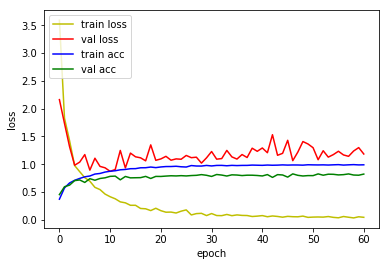

4815/4815 [==============================] - 15s 3ms/sample - loss: 1.0545 - acc: 0.7387
Loss: 1.0545296205043297 Accuracy: 0.7387331

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0487 - acc: 0.3958
Epoch 00001: val_loss improved from inf to 1.36275, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_4_conv_checkpoint/001-1.3627.hdf5
36805/36805 [==============================] - 373s 10ms/sample - loss: 2.0486 - acc: 0.3959 - val_loss: 1.3627 - val_acc: 0.5926
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1849 - acc: 0.6327
Epoch 00002: val_loss improved from 1.36275 to 0.91128, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_4_conv_checkpoint/002-0.9113.hdf5
36805/36805 [==============================] - 388s 11ms/sample - loss: 1.1849 - acc: 0.6328 - val_loss: 0.9113 - val_acc: 0.7205
Epoch 3/500
36800/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1491 - acc: 0.9520
Epoch 00026: val_loss did not improve from 0.49031
36805/36805 [==============================] - 396s 11ms/sample - loss: 0.1491 - acc: 0.9520 - val_loss: 0.6125 - val_acc: 0.8591
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1234 - acc: 0.9595
Epoch 00027: val_loss did not improve from 0.49031
36805/36805 [==============================] - 405s 11ms/sample - loss: 0.1236 - acc: 0.9594 - val_loss: 0.5969 - val_acc: 0.8744
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1329 - acc: 0.9560
Epoch 00028: val_loss did not improve from 0.49031
36805/36805 [==============================] - 393s 11ms/sample - loss: 0.1329 - acc: 0.9560 - val_loss: 0.5286 - val_acc: 0.8877
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1107 - acc: 0.9628
Epoch 00029: val_loss did not improve from 0.49031
36805/36805 [==================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9744
Epoch 00056: val_loss did not improve from 0.49031
36805/36805 [==============================] - 387s 11ms/sample - loss: 0.0864 - acc: 0.9743 - val_loss: 0.7033 - val_acc: 0.8812
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1006 - acc: 0.9700
Epoch 00057: val_loss did not improve from 0.49031
36805/36805 [==============================] - 408s 11ms/sample - loss: 0.1008 - acc: 0.9699 - val_loss: 0.6293 - val_acc: 0.8919
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9852
Epoch 00058: val_loss did not improve from 0.49031
36805/36805 [==============================] - 391s 11ms/sample - loss: 0.0480 - acc: 0.9851 - val_loss: 0.5837 - val_acc: 0.8966
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9849
Epoch 00059: val_loss did not improve from 0.49031
36805/36805 [=====

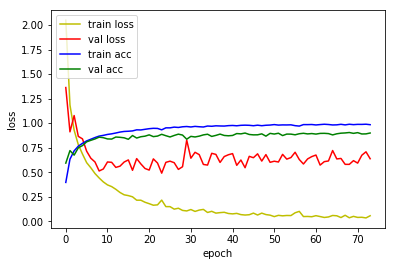

4815/4815 [==============================] - 15s 3ms/sample - loss: 0.5914 - acc: 0.8579
Loss: 0.5914090808554479 Accuracy: 0.85794395

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0040 - acc: 0.4029
Epoch 00001: val_loss improved from inf to 1.37358, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_5_conv_checkpoint/001-1.3736.hdf5
36805/36805 [==============================] - 411s 11ms/sample - loss: 2.0039 - acc: 0.4029 - val_loss: 1.3736 - val_acc: 0.5649
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1531 - acc: 0.6432
Epoch 00002: val_loss improved from 1.37358 to 1.13171, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_5_conv_checkpoint/002-1.1317.hdf5
36805/36805 [==============================] - 406s 11ms/sample - loss: 1.1532 - acc: 0.6432 - val_loss: 1.1317 - val_acc: 0.6683
Epoch 3/500
36800/36805 [====================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9608
Epoch 00026: val_loss did not improve from 0.35359
36805/36805 [==============================] - 409s 11ms/sample - loss: 0.1230 - acc: 0.9608 - val_loss: 0.5726 - val_acc: 0.8831
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1211 - acc: 0.9605
Epoch 00027: val_loss did not improve from 0.35359
36805/36805 [==============================] - 405s 11ms/sample - loss: 0.1212 - acc: 0.9604 - val_loss: 0.4676 - val_acc: 0.9008
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1168 - acc: 0.9621
Epoch 00028: val_loss did not improve from 0.35359
36805/36805 [==============================] - 408s 11ms/sample - loss: 0.1172 - acc: 0.9620 - val_loss: 0.5032 - val_acc: 0.8954
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1330 - acc: 0.9568
Epoch 00029: val_loss did not improve from 0.35359
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9868
Epoch 00056: val_loss did not improve from 0.35359
36805/36805 [==============================] - 408s 11ms/sample - loss: 0.0434 - acc: 0.9868 - val_loss: 0.4412 - val_acc: 0.9189
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9867
Epoch 00057: val_loss did not improve from 0.35359
36805/36805 [==============================] - 404s 11ms/sample - loss: 0.0433 - acc: 0.9866 - val_loss: 0.5934 - val_acc: 0.8905
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0574 - acc: 0.9817
Epoch 00058: val_loss did not improve from 0.35359
36805/36805 [==============================] - 408s 11ms/sample - loss: 0.0574 - acc: 0.9817 - val_loss: 0.4518 - val_acc: 0.9255
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9859
Epoch 00059: val_loss did not improve from 0.35359
36805/36805 [=====

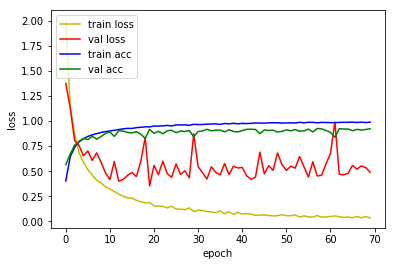

4815/4815 [==============================] - 15s 3ms/sample - loss: 0.4222 - acc: 0.8926
Loss: 0.42219577449009305 Accuracy: 0.8926272

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9904 - acc: 0.3868
Epoch 00001: val_loss improved from inf to 1.39049, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_6_conv_checkpoint/001-1.3905.hdf5
36805/36805 [==============================] - 419s 11ms/sample - loss: 1.9905 - acc: 0.3868 - val_loss: 1.3905 - val_acc: 0.5337
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1491 - acc: 0.6396
Epoch 00002: val_loss improved from 1.39049 to 1.09689, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_6_conv_checkpoint/002-1.0969.hdf5
36805/36805 [==============================] - 415s 11ms/sample - loss: 1.1493 - acc: 0.6396 - val_loss: 1.0969 - val_acc: 0.6648
Epoch 3/500
36800/36805 [====================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1047 - acc: 0.9657
Epoch 00027: val_loss improved from 0.25473 to 0.25299, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_6_conv_checkpoint/027-0.2530.hdf5
36805/36805 [==============================] - 415s 11ms/sample - loss: 0.1047 - acc: 0.9657 - val_loss: 0.2530 - val_acc: 0.9383
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1047 - acc: 0.9666
Epoch 00028: val_loss did not improve from 0.25299
36805/36805 [==============================] - 415s 11ms/sample - loss: 0.1050 - acc: 0.9666 - val_loss: 0.3873 - val_acc: 0.9115
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1123 - acc: 0.9617
Epoch 00029: val_loss did not improve from 0.25299
36805/36805 [==============================] - 414s 11ms/sample - loss: 0.1123 - acc: 0.9617 - val_loss: 0.3132 - val_acc: 0.9278
Epoch 30/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9851
Epoch 00055: val_loss did not improve from 0.24796
36805/36805 [==============================] - 413s 11ms/sample - loss: 0.0458 - acc: 0.9851 - val_loss: 0.2849 - val_acc: 0.9432
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9876
Epoch 00056: val_loss did not improve from 0.24796
36805/36805 [==============================] - 414s 11ms/sample - loss: 0.0377 - acc: 0.9876 - val_loss: 0.3422 - val_acc: 0.9345
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9873
Epoch 00057: val_loss did not improve from 0.24796
36805/36805 [==============================] - 414s 11ms/sample - loss: 0.0382 - acc: 0.9873 - val_loss: 0.3272 - val_acc: 0.9317
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9867
Epoch 00058: val_loss did not improve from 0.24796
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9912
Epoch 00084: val_loss did not improve from 0.24675
36805/36805 [==============================] - 412s 11ms/sample - loss: 0.0275 - acc: 0.9911 - val_loss: 0.3897 - val_acc: 0.9299
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9908
Epoch 00085: val_loss did not improve from 0.24675
36805/36805 [==============================] - 412s 11ms/sample - loss: 0.0291 - acc: 0.9908 - val_loss: 0.3209 - val_acc: 0.9406
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9921
Epoch 00086: val_loss did not improve from 0.24675
36805/36805 [==============================] - 412s 11ms/sample - loss: 0.0240 - acc: 0.9920 - val_loss: 0.3608 - val_acc: 0.9311
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9881
Epoch 00087: val_loss did not improve from 0.24675
36805/36805 [==================

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0164 - acc: 0.9946
Epoch 00114: val_loss did not improve from 0.24675
36805/36805 [==============================] - 412s 11ms/sample - loss: 0.0164 - acc: 0.9946 - val_loss: 0.2856 - val_acc: 0.9522
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9927
Epoch 00115: val_loss did not improve from 0.24675
36805/36805 [==============================] - 415s 11ms/sample - loss: 0.0224 - acc: 0.9927 - val_loss: 0.4383 - val_acc: 0.9297
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9909
Epoch 00116: val_loss did not improve from 0.24675
36805/36805 [==============================] - 414s 11ms/sample - loss: 0.0269 - acc: 0.9908 - val_loss: 0.3106 - val_acc: 0.9481
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9922
Epoch 00117: val_loss did not improve from 0.24675
36805/36805 [=

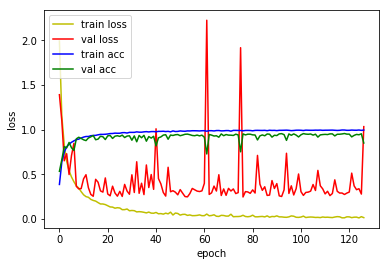

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.2997 - acc: 0.9350
Loss: 0.29974709408355804 Accuracy: 0.9349948

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1766 - acc: 0.3316
Epoch 00001: val_loss improved from inf to 1.51519, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_7_conv_checkpoint/001-1.5152.hdf5
36805/36805 [==============================] - 435s 12ms/sample - loss: 2.1767 - acc: 0.3316 - val_loss: 1.5152 - val_acc: 0.5181
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2245 - acc: 0.6104
Epoch 00002: val_loss improved from 1.51519 to 0.97042, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_7_conv_checkpoint/002-0.9704.hdf5
36805/36805 [==============================] - 428s 12ms/sample - loss: 1.2246 - acc: 0.6104 - val_loss: 0.9704 - val_acc: 0.7016
Epoch 3/500
36800/36805 [====================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1120 - acc: 0.9635
Epoch 00026: val_loss did not improve from 0.18820
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.1122 - acc: 0.9634 - val_loss: 0.2020 - val_acc: 0.9476
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1083 - acc: 0.9631
Epoch 00027: val_loss improved from 0.18820 to 0.17888, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_7_conv_checkpoint/027-0.1789.hdf5
36805/36805 [==============================] - 429s 12ms/sample - loss: 0.1083 - acc: 0.9631 - val_loss: 0.1789 - val_acc: 0.9474
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0939 - acc: 0.9693
Epoch 00028: val_loss did not improve from 0.17888
36805/36805 [==============================] - 430s 12ms/sample - loss: 0.0939 - acc: 0.9693 - val_loss: 0.2238 - val_acc: 0.9420
Epoch 29/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9876
Epoch 00054: val_loss did not improve from 0.14920
36805/36805 [==============================] - 430s 12ms/sample - loss: 0.0373 - acc: 0.9876 - val_loss: 0.1831 - val_acc: 0.9588
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9863
Epoch 00055: val_loss did not improve from 0.14920
36805/36805 [==============================] - 430s 12ms/sample - loss: 0.0424 - acc: 0.9863 - val_loss: 0.2243 - val_acc: 0.9495
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9837
Epoch 00056: val_loss did not improve from 0.14920
36805/36805 [==============================] - 432s 12ms/sample - loss: 0.0499 - acc: 0.9837 - val_loss: 0.3114 - val_acc: 0.9313
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9871
Epoch 00057: val_loss did not improve from 0.14920
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0223 - acc: 0.9931
Epoch 00083: val_loss did not improve from 0.14674
36805/36805 [==============================] - 433s 12ms/sample - loss: 0.0223 - acc: 0.9930 - val_loss: 0.2021 - val_acc: 0.9562
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9912
Epoch 00084: val_loss did not improve from 0.14674
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0274 - acc: 0.9912 - val_loss: 0.1733 - val_acc: 0.9623
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9911
Epoch 00085: val_loss did not improve from 0.14674
36805/36805 [==============================] - 431s 12ms/sample - loss: 0.0275 - acc: 0.9911 - val_loss: 0.1558 - val_acc: 0.9646
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9924
Epoch 00086: val_loss did not improve from 0.14674
36805/36805 [==================

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0182 - acc: 0.9945
Epoch 00113: val_loss did not improve from 0.14674
36805/36805 [==============================] - 433s 12ms/sample - loss: 0.0182 - acc: 0.9945 - val_loss: 0.1661 - val_acc: 0.9676
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9947
Epoch 00114: val_loss did not improve from 0.14674
36805/36805 [==============================] - 435s 12ms/sample - loss: 0.0166 - acc: 0.9947 - val_loss: 0.2216 - val_acc: 0.9525
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9943
Epoch 00115: val_loss did not improve from 0.14674
36805/36805 [==============================] - 431s 12ms/sample - loss: 0.0177 - acc: 0.9943 - val_loss: 0.1903 - val_acc: 0.9620
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9917
Epoch 00116: val_loss did not improve from 0.14674
36805/36805 [=

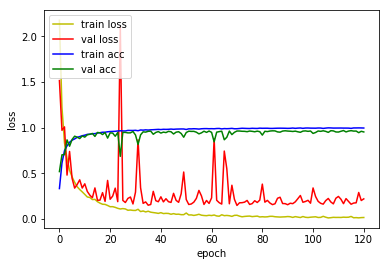

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.1993 - acc: 0.9514
Loss: 0.1992731784651228 Accuracy: 0.9514019

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2161 - acc: 0.3386
Epoch 00001: val_loss improved from inf to 1.20739, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_8_conv_checkpoint/001-1.2074.hdf5
36805/36805 [==============================] - 440s 12ms/sample - loss: 2.2161 - acc: 0.3386 - val_loss: 1.2074 - val_acc: 0.6313
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2003 - acc: 0.6164
Epoch 00002: val_loss improved from 1.20739 to 0.68292, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_8_conv_checkpoint/002-0.6829.hdf5
36805/36805 [==============================] - 431s 12ms/sample - loss: 1.2002 - acc: 0.6165 - val_loss: 0.6829 - val_acc: 0.8034
Epoch 3/500
36800/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0939 - acc: 0.9696
Epoch 00025: val_loss did not improve from 0.12689
36805/36805 [==============================] - 432s 12ms/sample - loss: 0.0939 - acc: 0.9696 - val_loss: 0.1335 - val_acc: 0.9625
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0793 - acc: 0.9744
Epoch 00026: val_loss did not improve from 0.12689
36805/36805 [==============================] - 432s 12ms/sample - loss: 0.0794 - acc: 0.9744 - val_loss: 0.1601 - val_acc: 0.9495
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0814 - acc: 0.9746
Epoch 00027: val_loss did not improve from 0.12689
36805/36805 [==============================] - 430s 12ms/sample - loss: 0.0817 - acc: 0.9745 - val_loss: 0.1604 - val_acc: 0.9513
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0879 - acc: 0.9716
Epoch 00028: val_loss did not improve from 0.12689
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9897
Epoch 00053: val_loss did not improve from 0.10723
36805/36805 [==============================] - 433s 12ms/sample - loss: 0.0346 - acc: 0.9896 - val_loss: 0.1539 - val_acc: 0.9602
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0531 - acc: 0.9840
Epoch 00054: val_loss did not improve from 0.10723
36805/36805 [==============================] - 435s 12ms/sample - loss: 0.0532 - acc: 0.9840 - val_loss: 0.1228 - val_acc: 0.9686
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9898
Epoch 00055: val_loss did not improve from 0.10723
36805/36805 [==============================] - 432s 12ms/sample - loss: 0.0324 - acc: 0.9898 - val_loss: 0.1090 - val_acc: 0.9716
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9896
Epoch 00056: val_loss improved from 0.10723 to 0.10278, saving model to model/chec

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9936
Epoch 00082: val_loss did not improve from 0.10064
36805/36805 [==============================] - 431s 12ms/sample - loss: 0.0212 - acc: 0.9936 - val_loss: 0.1496 - val_acc: 0.9683
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9959
Epoch 00083: val_loss did not improve from 0.10064
36805/36805 [==============================] - 429s 12ms/sample - loss: 0.0135 - acc: 0.9959 - val_loss: 0.1406 - val_acc: 0.9672
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.9954
Epoch 00084: val_loss did not improve from 0.10064
36805/36805 [==============================] - 430s 12ms/sample - loss: 0.0150 - acc: 0.9954 - val_loss: 0.1559 - val_acc: 0.9646
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9943
Epoch 00085: val_loss did not improve from 0.10064
36805/36805 [=====

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9977
Epoch 00112: val_loss did not improve from 0.10064
36805/36805 [==============================] - 433s 12ms/sample - loss: 0.0083 - acc: 0.9977 - val_loss: 0.1106 - val_acc: 0.9762
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0085 - acc: 0.9976
Epoch 00113: val_loss did not improve from 0.10064
36805/36805 [==============================] - 432s 12ms/sample - loss: 0.0088 - acc: 0.9976 - val_loss: 0.1176 - val_acc: 0.9690
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9939
Epoch 00114: val_loss did not improve from 0.10064
36805/36805 [==============================] - 432s 12ms/sample - loss: 0.0211 - acc: 0.9939 - val_loss: 0.1547 - val_acc: 0.9651
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9961
Epoch 00115: val_loss did not improve from 0.10064
36805/36805 [=

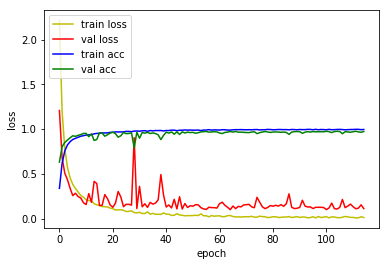

4815/4815 [==============================] - 16s 3ms/sample - loss: 0.1484 - acc: 0.9639
Loss: 0.14835858476761174 Accuracy: 0.96386296

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8736 - acc: 0.4520
Epoch 00001: val_loss improved from inf to 0.74232, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_9_conv_checkpoint/001-0.7423.hdf5
36805/36805 [==============================] - 476s 13ms/sample - loss: 1.8734 - acc: 0.4520 - val_loss: 0.7423 - val_acc: 0.7650
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7932 - acc: 0.7514
Epoch 00002: val_loss improved from 0.74232 to 0.42969, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_9_conv_checkpoint/002-0.4297.hdf5
36805/36805 [==============================] - 423s 11ms/sample - loss: 0.7932 - acc: 0.7514 - val_loss: 0.4297 - val_acc: 0.8721
Epoch 3/500
36800/36805 [===================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0505 - acc: 0.9843
Epoch 00026: val_loss did not improve from 0.10632
36805/36805 [==============================] - 409s 11ms/sample - loss: 0.0505 - acc: 0.9842 - val_loss: 0.1414 - val_acc: 0.9625
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9836
Epoch 00027: val_loss did not improve from 0.10632
36805/36805 [==============================] - 389s 11ms/sample - loss: 0.0536 - acc: 0.9836 - val_loss: 0.1371 - val_acc: 0.9611
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9815
Epoch 00028: val_loss improved from 0.10632 to 0.08217, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_BN_9_conv_checkpoint/028-0.0822.hdf5
36805/36805 [==============================] - 433s 12ms/sample - loss: 0.0565 - acc: 0.9815 - val_loss: 0.0822 - val_acc: 0.9755
Epoch 29/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9957
Epoch 00055: val_loss did not improve from 0.08217
36805/36805 [==============================] - 390s 11ms/sample - loss: 0.0146 - acc: 0.9956 - val_loss: 0.1500 - val_acc: 0.9644
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9917
Epoch 00056: val_loss did not improve from 0.08217
36805/36805 [==============================] - 430s 12ms/sample - loss: 0.0286 - acc: 0.9917 - val_loss: 0.1118 - val_acc: 0.9720
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9964
Epoch 00057: val_loss did not improve from 0.08217
36805/36805 [==============================] - 441s 12ms/sample - loss: 0.0136 - acc: 0.9963 - val_loss: 0.1198 - val_acc: 0.9702
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9942
Epoch 00058: val_loss did not improve from 0.08217
36805/36805 [==================

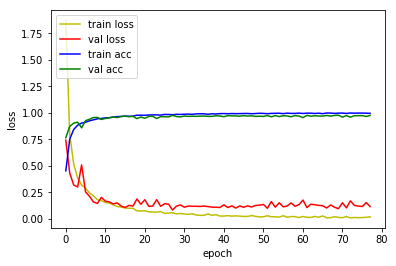

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.1158 - acc: 0.9664
Loss: 0.11580744909464942 Accuracy: 0.96635514



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_kernel_192_ch_128_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
    
    model = multi_gpu_model(model, gpus=2)
#         model.summary()

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_kernel_192_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_ch_128_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           6025104     lambda[0][0]                     
                                                         

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.1993 - acc: 0.9514
Loss: 0.1992731784651228 Accuracy: 0.9514019

1D_CNN_custom_kernel_192_ch_128_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequent

In [12]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_kernel_192_ch_128_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           6025104     lambda[0][0]                     
                                                         

4815/4815 [==============================] - 17s 3ms/sample - loss: 0.3097 - acc: 0.9364
Loss: 0.30966072024570573 Accuracy: 0.9364486

1D_CNN_custom_kernel_192_ch_128_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequen